In [1]:
import math
import os
import yaml
import numpy as np
import git
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.stats import kstest
from tools_util import readModelInputs, getFacDict
from pyrheautils import pathTranslate, prepPathTranslations
from stats import jointSamples, fullLogNormCRVFromMean, correctLogNormCRVForComponent
import phacsl.utils.formats.yaml_tools as yaml_tools

In [2]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_OC.yaml'
#runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_ChicagoLand.yaml'

inputDict = readModelInputs(runDesc)
prepPathTranslations(inputDict)
facDict = getFacDict(inputDict)


In [3]:
with open(pathTranslate('$(MODELDIR)/constants/hospital_constants.yaml'), 'rU') as f:
    hospConstants = yaml.load(f)
print hospConstants['icuLOSLogNormSigma']

OrderedDict([('value', 0.7), ('prov', 'OrangeCounty ICU_Estimated_LOS_7-22-09 BWH sd_ln value for category 2==total')])


## Derivation of meanLOSHosp ##

$fracPatientDaysHosp=1.0-fracPatientDaysICU$

$(A+B)*meanLOSHosp+B*meanLOSICU=(A+B)*meanLOS$

$(B*meanLOSICU)/((A+B)*meanLOS) = fracPatientDaysICU$

$(B*meanLOSICU)/fracPatientDaysICU = (A+B)*meanLOS$

$meanLOSICU/(fracPatientDaysICU*meanLOS) = (A+B)/B$

$(fracPatientDaysICU*meanLOS)/(meanLOSICU) = B/(A+B)$

$meanLOSHosp + (B/(A+B))*meanLOSICU = meanLOS$

$meanLOSHosp = meanLOS - (B/(A+B))*meanLOSICU$

In [4]:
def crvFromMeanAndLogNormSigma(meanV, logNormSigma):
    return fullLogNormCRVFromMean(meanV, logNormSigma)


In [5]:
def jointSamps(nSamps, aCRV, bCRV, frac):
    return jointSamples(nSamps, aCRV, bCRV, frac)

In [6]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [16, 4.5]

def plotit(samples, sampLbl, outerCRV, outerCRVLbl, titleStr):
    nBins = 200
    histoRange = [0.0, 20.0]
    nSamps = len(samples)
    scale = len(samples) * (histoRange[1] - histoRange[0])/nBins
    plt.hist(samples, bins=nBins, range=histoRange, label=sampLbl)
    xV = np.linspace(histoRange[0], histoRange[1], nBins)
    yV = scale * outerCRV.pdf(xV)
    plt.plot(xV, yV, '-', label=outerCRVLbl)
    plt.legend()
    plt.title(titleStr)
    plt.show()



## Correct via K-S matching ##

In [7]:
nSamps = 1000000
icuLOSLogNormSigma = hospConstants['icuLOSLogNormSigma']['value']

hospL = []
for fac, rec in facDict.items():
    if rec['category'] == 'HOSPITAL':
        hospL.append(fac)
hospL.sort()
print '%d pdfs to correct' % len(hospL)

corrD = {}
for fac in hospL:
    print 'Correcting %s' % fac
    hospLM = facDict[fac]['losModel']
    fracPatientDaysICU = facDict[fac]['fracAdultPatientDaysICU']['value']
    meanLOSICU = facDict[fac]['meanLOSICU']['value']

    mu = math.log(meanLOSICU) - (0.5 * icuLOSLogNormSigma * icuLOSLogNormSigma)
    icuLM = {'parms': [mu, icuLOSLogNormSigma], 'pdf': 'lognorm(mu=$0,sigma=$1)'}

    hospCRV = lognorm(hospLM['parms'][1], scale=math.exp(hospLM['parms'][0]))
    icuCRV = lognorm(icuLM['parms'][1], scale=math.exp(icuLM['parms'][0]))

    fracICU = (fracPatientDaysICU * hospCRV.mean())/icuCRV.mean()
    meanLOSHosp = hospCRV.mean() - (fracICU*icuCRV.mean())

    corrSigma = correctLogNormCRVForComponent(meanLOSHosp,
                                              0.1 * hospLM['parms'][1], hospLM['parms'][1],
                                              hospCRV, fracICU, icuCRV, nSamps)
    corrCRV = crvFromMeanAndLogNormSigma(meanLOSHosp, corrSigma)
    corrMu = math.log(meanLOSHosp) - (0.5 * corrSigma * corrSigma)
    corrLM = {'parms': [float(corrMu), float(corrSigma)], 'pdf': 'lognorm(mu=$0,sigma=$1)'}
    print '%s: %s' % (fac, corrLM)
    corrD[fac] = corrLM


22 pdfs to correct
Correcting ANGL
ANGL: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.5458666439378714, 0.7261166250553518]}
Correcting ANRG
ANRG: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.3709692216659133, 0.5043642174697941]}
Correcting CHAP
CHAP: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.3784468583708718, 0.7630086163283093]}
Correcting FVRH
FVRH: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.3931192442545601, 0.538697288345793]}
Correcting GGMC
GGMC: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.216238706224459, 0.4688755642458102]}
Correcting HBHO
HBHO: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.3653320726596068, 0.7037684812575931]}
Correcting HGOR
HGOR: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.0518374898341853, 0.2788310017329021]}
Correcting HOAG
HOAG: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.309585374184996, 0.5071005411412537]}
Correcting KAIA
KAIA: {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.2598970460974876, 0.5064855526081364]}
Correcting L

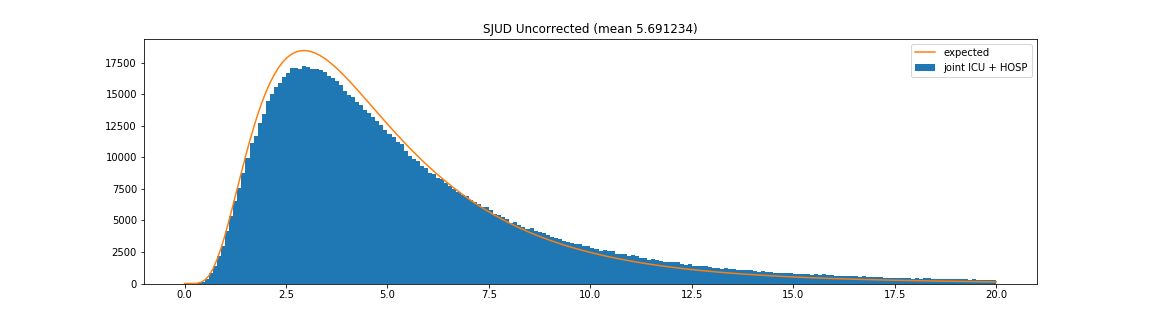

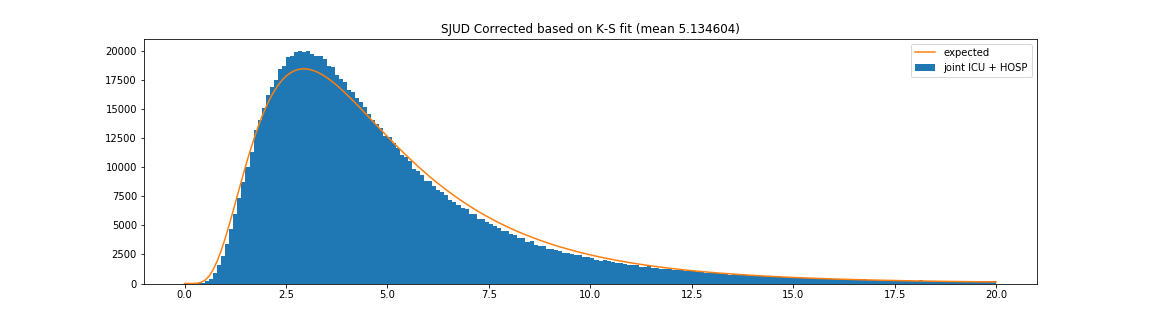

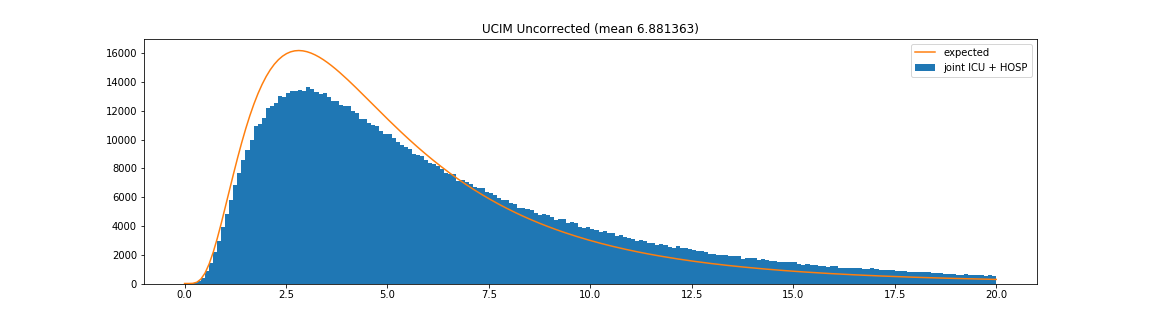

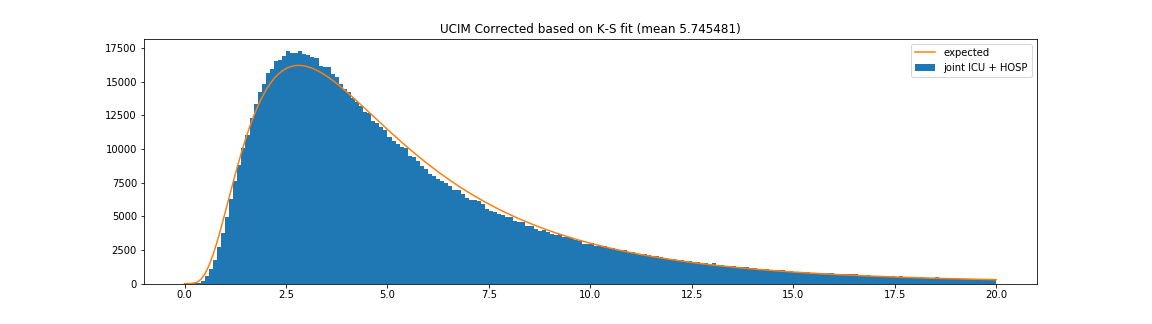

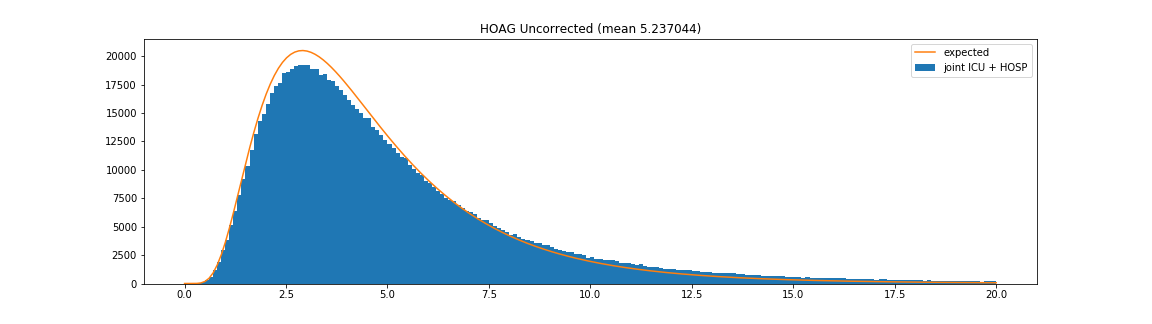

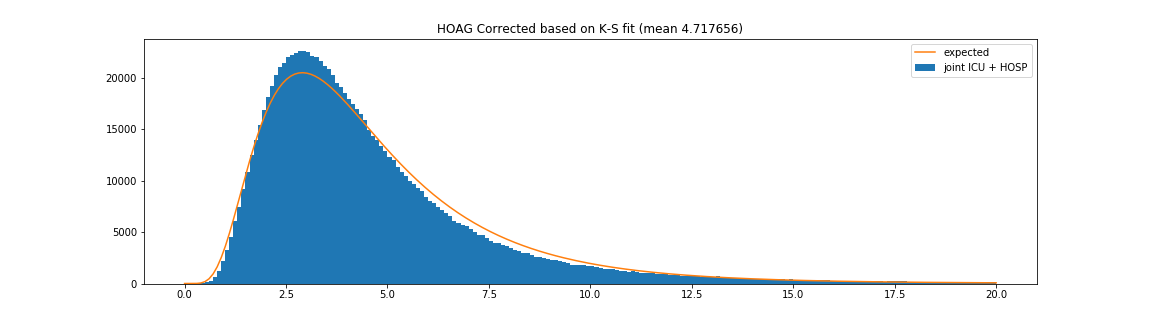

In [8]:
for fac in ['SJUD', 'UCIM', 'HOAG', 'PALO_12251_H', 'VHS_1225_H']:
    if fac not in facDict:
        continue
    hospLM = facDict[fac]['losModel']

    fracPatientDaysICU = facDict[fac]['fracAdultPatientDaysICU']['value']
    meanLOSICU = facDict[fac]['meanLOSICU']['value']
    mu = math.log(meanLOSICU) - (0.5 * icuLOSLogNormSigma * icuLOSLogNormSigma)
    icuLM = {'parms': [mu, icuLOSLogNormSigma], 'pdf': 'lognorm(mu=$0,sigma=$1)'}
    corrLM = corrD[fac]

    hospCRV = lognorm(hospLM['parms'][1], scale=math.exp(hospLM['parms'][0]))
    icuCRV = lognorm(icuLM['parms'][1], scale=math.exp(icuLM['parms'][0]))
    corrCRV = lognorm(corrLM['parms'][1], scale=math.exp(corrLM['parms'][0]))

    fracICU = (fracPatientDaysICU * hospCRV.mean())/icuCRV.mean()
    uncorSamps = jointSamps(nSamps, hospCRV, icuCRV, fracICU)
    uncorMean = np.mean(uncorSamps)
    plotit(uncorSamps, 'joint ICU + HOSP', 
           hospCRV, 'expected', '%s Uncorrected (mean %f)' % (fac, uncorMean))
    corSamps = jointSamps(nSamps, corrCRV, icuCRV, fracICU)
    corMean = np.mean(corSamps)
    plotit(corSamps, 'joint ICU + HOSP', 
           hospCRV, 'expected', '%s Corrected based on K-S fit (mean %f)' % (fac, corMean))

In [9]:
#with open('corr_pdfs.yaml', 'w') as f:
#    yaml.safe_dump(corrD, f, indent=4,
#                   encoding='utf-8', width=130, explicit_start=True)

In [13]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "nameOfThisNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [14]:
simStatus = git.cmd.Git(pathTranslate('$(SIMDIR)')).describe('--always', '--dirty')
modelStatus = git.cmd.Git(pathTranslate('$(MODELDIR)')).describe('--always', '--dirty')
print 'simStatus: %s' % simStatus
print 'modelStatus: %s' % modelStatus


simStatus: e73a085-dirty
modelStatus: bce5314


In [15]:
provS = "Generated using {0} notebook {1} based on model data {2}".format(nameOfThisNotebook,
                                                                         simStatus, modelStatus)
for fac, rec in corrD.items():
    rec.update({'prov': provS})
newFacDict = {}
for fac in hospL:
    rec = facDict[fac].copy()
    rec['correctedLOSModel'] = corrD[fac]
    newFacDict[fac] = rec

yaml_tools.save_all(pathTranslate('$(MODELDIR)/facilityfactsUpdated'), newFacDict.values())